In [ ]:
%pip install deap

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

df = pd.read_csv('./data/processed_mrna_zscore.csv')

In [2]:
X = df.iloc[:, :-2]
y = df.iloc[:, -1]

Select 500 features by filtering methods.

In [3]:
file_path = './top_features_rf_500.txt'

with open(file_path, 'r') as file:
    content = file.read().splitlines()
top500 = content

The search space is now in 500 top features selected by a filtering methods

In [4]:
target_n = 50

In [5]:
import random
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.model_selection import StratifiedKFold
# Assuming X and y are your feature matrix and target variable
# X is a pandas DataFrame with 1800 samples and 500 features
# y is a pandas Series with the corresponding labels

# DEAP initialization
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Function to create an individual (binary representation of features)
def create_individual():
    return np.random.choice(top500, size=target_n, replace=False)

def mutate(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            remain = [feat for feat in top500 if feat not in individual]
            individual[i] = np.random.choice(remain)

    return individual,
# DEAP Toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

Genetic algorithm settings

In [6]:
population_size = 50
generations = 20
crossover_rate = 0.8
mutation_rate = 0.1

In [7]:
def execuate_ga(clf):
    # Collect fitness values for plotting
    mean_fitness_values = []

    population = toolbox.population(n=population_size)

    for gen in range(generations):
        # Evaluate the entire population
        fitness_values = list(toolbox.map(toolbox.evaluate, population))
        
        # Update the fitness values
        for ind, fit in zip(population, fitness_values):
            ind.fitness.values = fit
        
        # Select the next generation individuals
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
        
        # Evaluate offspring
        fitness_values = list(toolbox.map(toolbox.evaluate, offspring))
        for ind, fit in zip(offspring, fitness_values):
            ind.fitness.values = fit
        
        # Select the next generation from offspring
        population = toolbox.select(offspring + population, k=population_size)
        
        # Collect the highest fitness value for this generation
        mean_fitness = np.array([ind.fitness.values[0] for ind in population]).mean()
        mean_fitness_values.append(mean_fitness)

        # Print the highest fitness value for this generation
        print(f"Generation {gen + 1}: Mean Fitness = {mean_fitness}")

    
    # Plotting
    plt.plot(range(1, generations + 1), mean_fitness_values, marker='o')
    plt.xlabel('Generation')
    plt.ylabel('Mean Fitness Value')
    plt.title('Evolution of Highest Fitness Value')
    plt.show()

    # Get the best individual from the final population
    best_individual = tools.selBest(population, k=1)[0]


    np.savetxt(f'top_features_gen_{clf}.txt', best_individual, fmt='%s')

    print("Best individual:", best_individual)

    return mean_fitness_values

SVM

In [14]:
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Function to evaluate the fitness of an individual
def evaluate_individual_svm(individual):
    selected_features = individual
    # print('selected_features: ', selected_features)
    
    if not selected_features:
        return 0.0,  # Avoid all-zero individuals
    
    clf = LinearSVC(random_state=42, dual='auto')
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    sel_X = X[selected_features]
    for train_index, test_index in skf.split(sel_X, y):
        X_train, X_test = sel_X.iloc[train_index], sel_X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        clf.fit(X_resampled, y_resampled)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    return average_accuracy,

Generation 1: Mean Fitness = 0.575787878787879
Generation 2: Mean Fitness = 0.5883333333333334
Generation 3: Mean Fitness = 0.5993838383838382
Generation 4: Mean Fitness = 0.6092222222222222
Generation 5: Mean Fitness = 0.6170606060606061
Generation 6: Mean Fitness = 0.620090909090909
Generation 7: Mean Fitness = 0.6223333333333333
Generation 8: Mean Fitness = 0.624919191919192
Generation 9: Mean Fitness = 0.6275555555555555
Generation 10: Mean Fitness = 0.6311212121212121
Generation 11: Mean Fitness = 0.6340606060606061
Generation 12: Mean Fitness = 0.6392929292929292
Generation 13: Mean Fitness = 0.6428181818181818
Generation 14: Mean Fitness = 0.6434343434343434
Generation 15: Mean Fitness = 0.6438484848484849
Generation 16: Mean Fitness = 0.6444747474747474
Generation 17: Mean Fitness = 0.6453636363636365
Generation 18: Mean Fitness = 0.6460303030303031
Generation 19: Mean Fitness = 0.6467777777777778
Generation 20: Mean Fitness = 0.6477272727272728


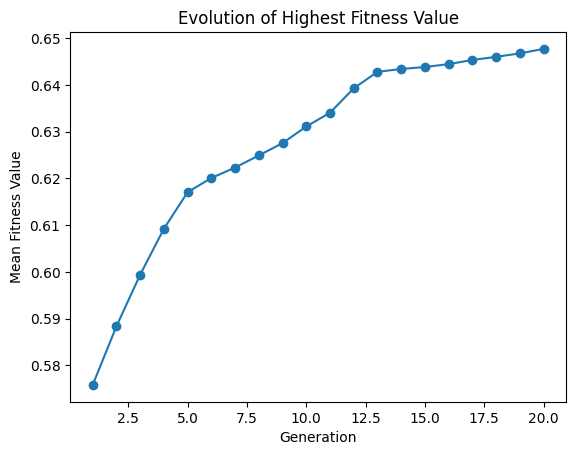

Best individual: ['ADCY5', 'TMEM165', 'MCL1', 'KANK1', 'STX1B', 'TBC1D1', 'HDAC5', 'MCL1', 'KRTAP5-3', 'USHBP1', 'HAUS8', 'MAGEC2', 'DGKK', 'SNRPD2', 'COQ7', 'SLC25A5', 'CBWD1', 'SKP2', 'IL6ST', 'DGKK', 'FGA', 'IL6', 'CCDC96', 'SNRPA1', 'LRRC8A', 'SLC41A3', 'ABITRAM', 'MUC19', 'BROX', 'KANK1', 'ANP32AP1', 'GJA5', 'SPDYE2', 'CCDC9B', 'GBA2', 'HMGA1', 'ST8SIA2', 'CCDC170', 'PPP1R14B', 'ANGPT2', 'ADD2', 'S100A7', 'AL137655', 'SRSF10', 'PADI1', 'TIMM13', 'RORB', 'PGAP3', 'UPF2', 'CA9']


[0.575787878787879,
 0.5883333333333334,
 0.5993838383838382,
 0.6092222222222222,
 0.6170606060606061,
 0.620090909090909,
 0.6223333333333333,
 0.624919191919192,
 0.6275555555555555,
 0.6311212121212121,
 0.6340606060606061,
 0.6392929292929292,
 0.6428181818181818,
 0.6434343434343434,
 0.6438484848484849,
 0.6444747474747474,
 0.6453636363636365,
 0.6460303030303031,
 0.6467777777777778,
 0.6477272727272728]

In [15]:
toolbox.register("evaluate", evaluate_individual_svm)
execuate_ga('svm')

In [ ]:
mean_fitness_values = [0.575787878787879,
 0.5883333333333334,
 0.5993838383838382,
 0.6092222222222222,
 0.6170606060606061,
 0.620090909090909,
 0.6223333333333333,
 0.624919191919192,
 0.6275555555555555,
 0.6311212121212121,
 0.6340606060606061,
 0.6392929292929292,
 0.6428181818181818,
 0.6434343434343434,
 0.6438484848484849,
 0.6444747474747474,
 0.6453636363636365,
 0.6460303030303031,
 0.6467777777777778,
 0.6477272727272728]

plt.plot(range(1, generations + 1), mean_fitness_values, marker='o', color='orange')
plt.xlabel('Generation')
plt.ylabel('Mean Fitness Value')
plt.title('Mean Fitness Value - GA and SVM')
plt.show()